In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skdat
from ipywidgets import interact

# Generate fake data

Text(0.5, 1.0, 'True signal')

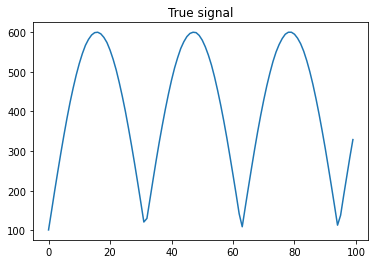

In [2]:
img_box = (-1, 1)

signal_level = 500
noise_level = 1000

opt = {
    'centers': [[0.0, 0.0]],
    'cluster_std': 0.2,
    'n_features': 2 # Dimension
}
opt['center_box'] = (img_box[0]+2*opt['cluster_std'], img_box[1]-2*opt['cluster_std'])

num_frames = 100
signal_baseline = 100
amp_true = signal_baseline + signal_level*abs(np.sin(np.arange(num_frames)/10))+1
amp_true = [int(a) for a in amp_true]

plt.plot(amp_true)
plt.title("True signal")

In [3]:
amp_true[9]

492

In [4]:
all_dat = []
all_noise = []

for i in range(num_frames):
    dat, _ = skdat.make_blobs(n_samples=amp_true[i], **opt)
    all_dat.append(dat)
    noise = 2*(-0.5 + np.random.rand(noise_level, 2))
    all_noise.append(noise)

In [5]:
def f(i):
    plt.scatter(all_noise[i][:,0], all_noise[i][:,1], label='noise')
    plt.scatter(all_dat[i][:,0], all_dat[i][:,1], label='signal')
    plt.legend()
    plt.title('Real signal')

interact(f, i=(0,num_frames))

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.f(i)>

# Build histogram (i.e. image)

In [6]:
noisy_dat = [np.vstack([n, d]) for n, d in zip(all_noise, all_dat)]

In [7]:
pixel_sz = 0.1
bins = int(np.ceil(2.0 / pixel_sz))

vid_noisy = np.zeros((num_frames, bins, bins))
vid_clean = np.zeros((num_frames, bins, bins))

for i, (noisy_dat, dat) in enumerate(zip(noisy_dat, all_dat)):
    vid_noisy[i,...] = np.histogram2d(noisy_dat[:,0], noisy_dat[:,1], bins=bins)[0]
    vid_clean[i,...] = np.histogram2d(dat[:,0], dat[:,1], bins=bins)[0]

In [8]:
def f(i):
    plt.imshow(vid_noisy[i])

interact(f, i=(0,num_frames))

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.f(i)>

In [9]:
# plt.imshow(img_clean)
# plt.colorbar()

# Draw a mask by hand

In [10]:
import napari

In [11]:
vid_clean[0,...].shape

(20, 20)

In [12]:
viewer = napari.view_image(vid_noisy)
# labels_layer = viewer.add_(np.zeros_like(img), name='segmentation')

C:\Users\charl\.julia\conda\3\envs\DLC-for-WBFM\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


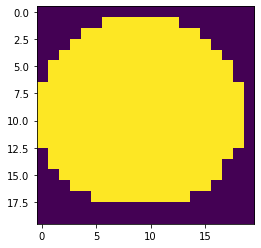

In [19]:
############# DRAW BY HAND
mask_layer = viewer.layers['Shapes']
masks = mask_layer.to_labels(vid_clean[0].shape)
# masks
plt.imshow(masks)

# Calculate traces in various ways

In [20]:
# amp_true = opt['n_samples']
# noise_true = np.sqrt(opt['n_samples']) # Shot noise

# print(f"Given shot noise, best we can do is {amp_true} +- {noise_true}")

### First: just ROI

In [21]:
all_labels = np.unique(masks)[1:] # Remove 0=background
all_labels

array([1])

In [22]:
amp_roi_clean = {}
amp_roi_noisy = {}

def get_amps_roi(mask, vid, back_per_pix=0):
    background = back_per_pix*np.count_nonzero(mask)
    return np.array([np.sum(img[mask])-background for img in vid])

background_per_pixel = np.mean(get_amps_roi(masks==0, vid_noisy)/np.count_nonzero(masks==0))
print(f"Estimated background per pixel to be: {background_per_pixel}")

for label in all_labels:
    this_mask = masks==label
    
    amp_roi_clean[label] = get_amps_roi(this_mask, vid_clean)
    amp_roi_noisy[label] = get_amps_roi(this_mask, vid_noisy, background_per_pixel)


Estimated background per pixel to be: 2.505441176470588


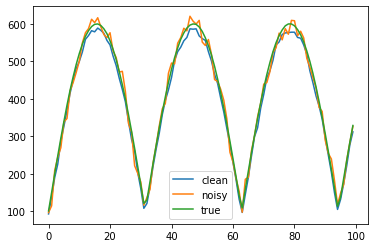

In [23]:
plt.plot(amp_roi_clean[1], label="clean")
plt.plot(amp_roi_noisy[1], label="noisy")
plt.plot(amp_true, label="true")
plt.legend()

### Second: ROI with top percentile

In [24]:
all_labels = np.unique(masks)[1:] # Remove 0=background
all_labels

array([1])

In [25]:
amp_quantile_clean = {}
amp_quantile_noisy = {}

quantile = 0.5

def get_amps_quantile(mask, vid, quantile, back_per_pix=0):
    trace = []
    for img in vid:
        vals = img[mask]
        thresh = np.quantile(vals, quantile)
        submask = vals>thresh
        
        background = back_per_pix*np.count_nonzero(submask)
        trace.append(np.sum(vals[submask]) - background)
    return np.array(trace)

background_per_pixel = np.mean(get_amps_roi(masks==0, vid_noisy)/np.count_nonzero(masks==0))
print(f"Estimated background per pixel to be: {background_per_pixel}")

for label in all_labels:
    this_mask = masks==label
    
    amp_quantile_clean[label] = get_amps_quantile(this_mask, vid_clean, quantile)
    amp_quantile_noisy[label] = get_amps_quantile(this_mask, vid_clean, quantile, background_per_pixel)


Estimated background per pixel to be: 2.505441176470588


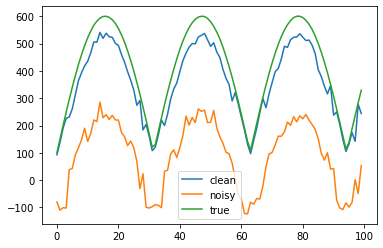

In [26]:
plt.plot(amp_quantile_clean[1], label="clean")
plt.plot(amp_quantile_noisy[1], label="noisy")
plt.plot(amp_true, label="true")
plt.legend()

### Third: Fit the histogram

In [27]:
from scipy.optimize import curve_fit

In [28]:
amp_hist_clean = {}
amp_hist_noisy = {}

def to_fit(x, sigma):
    # Maxwell-boltzmann in 3d, Rayleigh in 2d
    s2 = sigma**2.0
    return (x/s2) * np.exp(-x**2/s2)

# def to_fit2(x, sigma1, sigma2):
#     # Two distributions, one for background
#     s12 = sigma1**2.0
#     s22 = sigma2**2.0
#     return (x/s12) * np.exp(-x**2/s12) + (x/s12) * np.exp(-x**2/s12)

# edges = np.arange(0, max(vals)+pixel_sz, pixel_sz)
edges = np.arange(np.max(vid_noisy[10])+1)

def get_amps_hist(mask, vid, back_per_pix=0):
    trace = []
    for img in vid:
        vals = np.ravel(img[mask])
        subtracted_vals = np.clip(vals - back_per_pix, 0, 1000)
        hist_dat, _ = np.histogram(subtracted_vals[subtracted_vals>0], bins=edges)
        popt, _ = curve_fit(to_fit, edges[:-1], hist_dat)
        trace.append(popt[0]*np.sum(subtracted_vals))
        
    return np.array(trace)

background_per_pixel = np.mean(get_amps_roi(masks==0, vid_noisy)/np.count_nonzero(masks==0))
print(f"Estimated background per pixel to be: {background_per_pixel}")

for label in all_labels:
    this_mask = masks==label
    
    amp_hist_clean[label] = get_amps_hist(this_mask, vid_clean)
    amp_hist_noisy[label] = get_amps_hist(this_mask, vid_noisy, background_per_pixel)


Estimated background per pixel to be: 2.505441176470588


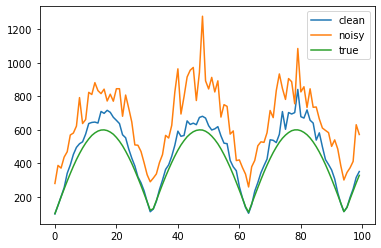

In [29]:
plt.plot(amp_hist_clean[1], label="clean")
plt.plot(amp_hist_noisy[1], label="noisy")
plt.plot(amp_true, label="true")
plt.legend()

In [30]:
this_mask = masks==1
vals = np.ravel(np.clip(vid_noisy[10][this_mask]-background_per_pixel, 0, 100))

# edges = np.arange(0, max(vals)+pixel_sz, pixel_sz)
edges = np.arange(min(vals), max(vals)+1)
hist_dat, _ = np.histogram(vals, bins=edges, density=True)

popt, _ = curve_fit(to_fit, edges[:-1], hist_dat)#, p0=(100, pixel_sz))

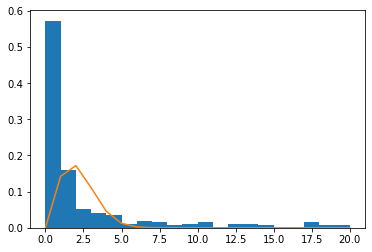

In [31]:
# plt.plot(hist_dat, 'o')
plt.hist(vals, bins=edges, density=True)
plt.plot(edges, to_fit(edges, *popt))

In [32]:
popt[0]*np.sum(vals)

1507.343694464928

In [ ]:
vals - background_per_pixel

In [ ]:
amp_true[10]